In [1]:
import numpy as np
import math
import pandas as pd
import os
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython
from IPython.display import Audio
from IPython.display import Image

import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedGroupKFold
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import KFold
import seaborn as sn
import sklearn
from sklearn.manifold import TSNE
from imblearn.metrics import sensitivity_specificity_support



In [2]:
DATA_PATH_Gita = os.path.abspath(os.getcwd()).split('Codigos')[0]+'Parkinson_datasets/Gita/Pataka'

SAMPLE_RATE = 44100
#AVPEPUDEAC0001_pataka
data_Gita = pd.DataFrame(columns=['Speaker_ID', 'Label', 'Path'])
Speaker_PD=0
Speaker_HC=50

for dirname, _, filenames in os.walk(DATA_PATH_Gita):
    
    for filename in filenames:
        file_path = os.path.join(dirname, filename)

        if dirname.find('PD')!=-1:
            Speaker_PD+=1
            Speaker_ID=Speaker_PD
            Label=1
        else: 
            Speaker_HC+=1
            Speaker_ID=Speaker_HC
            Label=0

            
        data_Gita=pd.concat([data_Gita, pd.DataFrame({"Speaker_ID": [Speaker_ID],
                            "Label": [Label],
                            "Path": [file_path]
                             })],ignore_index=True)
print("number of files is {}".format(len(data_Gita)))
data_Gita.head()

number of files is 100


,Speaker_ID,Label,Path
0,1,1,/home/byo/Documents/Experiments_EmiroIbarra/Pa...
1,2,1,/home/byo/Documents/Experiments_EmiroIbarra/Pa...
2,3,1,/home/byo/Documents/Experiments_EmiroIbarra/Pa...
3,4,1,/home/byo/Documents/Experiments_EmiroIbarra/Pa...
4,5,1,/home/byo/Documents/Experiments_EmiroIbarra/Pa...


In [3]:
DATA_PATH_NeuroV = os.path.abspath(os.getcwd()).split('Codigos')[0]+'Parkinson_datasets/BDatos Neurovoz/PorMaterial_limpios1_2_downsized/PATAKA'

SAMPLE_RATE = 44100
data_NeuroV = pd.DataFrame(columns=['Speaker_ID', 'Label', 'Path'])
for dirname, _, filenames in os.walk(DATA_PATH_NeuroV):
    for filename in filenames:
            file_path = os.path.join(dirname, filename)
            if filename.find('wav')!=-1:
                identifiers=filename.split('.')[0].split('_')
                Speaker_ID=int(identifiers[2])+100
                if identifiers[0]=='PD':
                    Label=1
                else:
                    Label=0
            data_NeuroV=pd.concat([data_NeuroV, pd.DataFrame({"Speaker_ID": [Speaker_ID],
                            "Label": [Label],
                            "Path": [file_path]
                             })],ignore_index=True)
print("number of files is {}".format(len(data_NeuroV)))
data_NeuroV.head()


number of files is 86


,Speaker_ID,Label,Path
0,169,1,/home/byo/Documents/Experiments_EmiroIbarra/Pa...
1,120,1,/home/byo/Documents/Experiments_EmiroIbarra/Pa...
2,137,1,/home/byo/Documents/Experiments_EmiroIbarra/Pa...
3,108,1,/home/byo/Documents/Experiments_EmiroIbarra/Pa...
4,209,1,/home/byo/Documents/Experiments_EmiroIbarra/Pa...


In [4]:
print('Data Gita')
print('Parkinson')
PD_Gita=data_Gita[data_Gita['Label']==1].sort_values(by=['Speaker_ID'])['Speaker_ID'].unique()
print(PD_Gita)
print('size=', PD_Gita.shape)
print('Control')
HC_Gita=data_Gita[data_Gita['Label']==0].sort_values(by=['Speaker_ID'])['Speaker_ID'].unique()
print(HC_Gita)
print('size=', HC_Gita.shape)

print('Data NeuroVoz')
print('Parkinson')
PD_NeuroV=data_NeuroV[data_NeuroV['Label']==1].sort_values(by=['Speaker_ID'])['Speaker_ID'].unique()
print(PD_NeuroV)
print('size=', PD_NeuroV.shape)
print('Control')
HC_NeuroV=data_NeuroV[data_NeuroV['Label']==0].sort_values(by=['Speaker_ID'])['Speaker_ID'].unique()
print(HC_NeuroV)
print('size=', HC_NeuroV.shape)

Data Gita
Parkinson
[1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50]
size= (50,)
Control
[51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74
 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98
 99 100]
size= (50,)
Data NeuroVoz
Parkinson
[106 107 108 109 110 111 112 113 115 116 117 118 119 120 124 125 127 128
 129 130 131 132 133 135 137 138 139 140 141 142 143 144 146 147 166 168
 169 170 177 209 211 213 215 217]
size= (44,)
Control
[134 136 148 149 151 152 153 154 155 156 160 161 162 163 164 172 174 175
 176 181 182 185 186 205 212 216 218 220 222 228 230 231 232 234 236 237
 238 240 241 242 243 245]
size= (42,)


In [5]:
#Partition Gita
Train_Subject_Gita=np.concatenate([PD_Gita, HC_Gita])
print("Data Gita")
print("To train:",np.unique(Train_Subject_Gita).shape)
data_train_Gita=data_Gita.loc[data_Gita['Speaker_ID'].isin(Train_Subject_Gita)]


#Partition NeuroVoz
Train_Subject_NeuroV=np.concatenate([PD_NeuroV, HC_NeuroV])
print("Data NeuroVoz")
print("To train:",np.unique(Train_Subject_NeuroV).shape)
data_train_NeuroV=data_NeuroV.loc[data_NeuroV['Speaker_ID'].isin(Train_Subject_NeuroV)]


Data Gita
To train: (100,)
Data NeuroVoz
To train: (86,)


In [6]:
#selecting 400ms overlap in 50ms of audio signal example
def process_select_signals(data, SAMPLE_RATE):
    time_leng=0.4
    sample_leng=int(time_leng*SAMPLE_RATE)
    overloap=2
    signals, y_label, subject_group, tono =[],[],[],[]


    #Processs data to train
    for data_ind, file_path in enumerate(data.Path):
        audio, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)
        audio_len=len(audio)
        #print(audio_len)
        #plt.plot(audio)
        audio=audio/np.max(abs(audio))
        indx=[i for i,x in enumerate(np.sqrt(abs(audio))) if x>.30]
        segments=0
        if (indx[0]+sample_leng)<audio_len:
            for i in range(int((-indx[0]+indx[len(indx)-1])/(sample_leng/overloap))):
                ind_start = i * int(sample_leng/overloap)+indx[0]
                ind_end = ind_start + sample_leng
                if ind_end <= indx[len(indx)-1]:
                    signal=np.zeros(sample_leng)
                    signal = audio[ind_start:int(ind_end)]
                    signals.append(signal)
            
                    y_label.append(data.iloc[data_ind]['Label'])
                    subject_group.append(data.iloc[data_ind]['Speaker_ID'])
                    segments=segments+1
            print(" Processed {}/{} files".format(data_ind,len(data)-1),end='')
            print(" Time audio: {} Segments {} ".format((audio_len-1)/sample_rate,segments))
        else:
             print(" Processed {}/{} files".format(data_ind,len(data)-1),end='')
             print(" Time audio: {} Segments {} ".format((audio_len-1)/sample_rate,0))
    signals = np.stack(signals,axis=0)
    y_label = np.stack(y_label,axis=0)
    subject_group = np.stack(subject_group,axis=0)
    return signals, y_label, subject_group


In [7]:
signals_train_Gita, y_label_train_Gita, subject_group_train_Gita = process_select_signals(data_train_Gita, SAMPLE_RATE)
print('size data train', signals_train_Gita.shape)

signals_train_NeuroV, y_label_train_NeuroV, subject_group_train_NeuroV = process_select_signals(data_train_NeuroV, SAMPLE_RATE)
print('size data train', signals_train_NeuroV.shape)


 Processed 0/99 files Time audio: 2.519614512471655 Segments 10 
 Processed 1/99 files Time audio: 5.553083900226757 Segments 25 
 Processed 2/99 files Time audio: 1.9452380952380952 Segments 7 
 Processed 3/99 files Time audio: 2.5204761904761903 Segments 9 
 Processed 4/99 files Time audio: 4.17984126984127 Segments 19 
 Processed 5/99 files Time audio: 1.4207709750566893 Segments 5 
 Processed 6/99 files Time audio: 3.325034013605442 Segments 14 
 Processed 7/99 files Time audio: 4.467210884353742 Segments 20 
 Processed 8/99 files Time audio: 1.7343990929705215 Segments 7 
 Processed 9/99 files Time audio: 2.5707482993197277 Segments 11 
 Processed 10/99 files Time audio: 2.364512471655329 Segments 10 
 Processed 11/99 files Time audio: 6.068208616780045 Segments 28 
 Processed 12/99 files Time audio: 6.52859410430839 Segments 30 
 Processed 13/99 files Time audio: 2.7931519274376417 Segments 12 
 Processed 14/99 files Time audio: 4.131632653061224 Segments 19 
 Processed 15/99 fil

 Processed 25/85 files Time audio: 7.265124716553288 Segments 35 
 Processed 26/85 files Time audio: 11.032675736961451 Segments 53 
 Processed 27/85 files Time audio: 8.51047619047619 Segments 41 
 Processed 28/85 files Time audio: 7.806507936507937 Segments 37 
 Processed 29/85 files Time audio: 6.925215419501134 Segments 33 
 Processed 30/85 files Time audio: 8.445668934240363 Segments 40 
 Processed 31/85 files Time audio: 12.863718820861678 Segments 62 
 Processed 32/85 files Time audio: 14.73766439909297 Segments 72 
 Processed 33/85 files Time audio: 14.364671201814058 Segments 70 
 Processed 34/85 files Time audio: 10.024807256235828 Segments 48 
 Processed 35/85 files Time audio: 6.00172335600907 Segments 28 
 Processed 36/85 files Time audio: 16.683718820861678 Segments 82 
 Processed 37/85 files Time audio: 11.23702947845805 Segments 54 
 Processed 38/85 files Time audio: 12.621655328798186 Segments 59 
 Processed 39/85 files Time audio: 3.9514739229024944 Segments 18 
 Proc

In [8]:
def compute_norm_spect(signals, sample_rate):
    n_fft = 2048
    win_length = int(0.015*sample_rate) 
    hop_length = int(0.010*sample_rate)
    n_mels = 65 

    mel_spectrogram = T.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=n_fft,
        win_length=win_length,
        hop_length=hop_length,
        center=True,
        pad_mode="reflect",
        power=2.0,
        norm="slaney",
        onesided=True,
        n_mels=n_mels,
        mel_scale="htk",
    )


    mel_spectrograms = []
    scaler = StandardScaler()
    print("Calculating mel spectrograms")
    for i in range(signals.shape[0]):
        mel_spect = librosa.power_to_db(mel_spectrogram(torch.from_numpy(signals[i,:])))
        mel_spect_norm=scaler.fit_transform(mel_spect)
        mel_spectrograms.append(mel_spect_norm)
        print("\r Processed {}/{} files".format(i,signals.shape[0]),end='')
    mel_spectrograms = np.stack(mel_spectrograms,axis=0)
    print(' ')
    return mel_spectrograms



In [9]:
mel_spectrograms_train_Gita=compute_norm_spect(signals_train_Gita, SAMPLE_RATE)
print('Data size:',mel_spectrograms_train_Gita.shape)

mel_spectrograms_train_NeuroV=compute_norm_spect(signals_train_NeuroV, SAMPLE_RATE)
print('Data size:',mel_spectrograms_train_NeuroV.shape)


Calculating mel spectrograms
 Processed 248/1962 files

/usr/local/anaconda3/lib/python3.10/site-packages/torchaudio/transforms/_transforms.py:611: UserWarning: Argument 'onesided' has been deprecated and has no influence on the behavior of this module.
  warnings.warn(


 Processed 1961/1962 files 
Data size: (1962, 65, 41)
Calculating mel spectrograms
 Processed 325/4985 files

/usr/local/anaconda3/lib/python3.10/site-packages/torchaudio/transforms/_transforms.py:611: UserWarning: Argument 'onesided' has been deprecated and has no influence on the behavior of this module.
  warnings.warn(


 Processed 4984/4985 files 
Data size: (4985, 65, 41)


In [10]:
class CNN(nn.Module):
        
        def __init__(self, kernel_size_1=8, kernel_size_2=9, depth_CL=64, neurons_MLP=64, drop_out=0.2):
            super().__init__()
            
            # 1. conv block
            self.conv2Dblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1,
                       out_channels=depth_CL,
                       kernel_size=kernel_size_1,
                       stride=1,
                       padding=1
                      ),
            nn.BatchNorm2d(depth_CL),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p=drop_out),
            )
            
            # 2. conv block
            self.conv2Dblock2 = nn.Sequential(
            nn.Conv2d(in_channels=depth_CL,
                       out_channels=depth_CL,
                       kernel_size=kernel_size_2,
                       stride=1,
                       padding=1
                      ),
            nn.BatchNorm2d(depth_CL),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p=drop_out),
            
            )
        
            self.MLP = nn.Sequential(
                nn.Linear(depth_CL*math.ceil((math.ceil((65-kernel_size_1)/2+1)-kernel_size_2)/2+1)
                          *math.ceil((math.ceil((41-kernel_size_1)/2+1)-kernel_size_2)/2+1),neurons_MLP),
            nn.ReLU(),
            nn.Dropout(p=drop_out),
            )
            
            self.out_softmax = nn.Sequential(
                nn.Linear(neurons_MLP,2),
                nn.Softmax(dim=1)
            )
            

        def forward(self,x):
            x = self.conv2Dblock1(x) 
            conv_embedding = self.conv2Dblock2(x) 
            conv_embedding = torch.flatten(conv_embedding, start_dim=1) 
            MPL_output = self.MLP(conv_embedding)
            output_softmax = self.out_softmax(MPL_output)
            return output_softmax, MPL_output

In [11]:
def reset_weights(m):
    for layer in m.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

def soft_output_by_subject(output_test, Y_test, subject_group_test, ):

    Y_test_bySubject= []
    output_test_bySubjects=torch.empty((1,2),device=output_test.device.type)
    subject_in_group=np.unique(subject_group_test)
    output_test_subject=torch.zeros(subject_in_group.shape)
    Y_estimated_test_subject=torch.ones(subject_in_group.shape)
    for i, speaker in enumerate(subject_in_group):
        index_speaker = np.where(subject_group_test==speaker)
        output_test_subject[i]=torch.mean(torch.log(output_test[index_speaker][:,1]) -torch.log(output_test[index_speaker][:,0]),0)
        Y_test_bySubject.append(Y_test[index_speaker][0])
        
            
    Y_test_tensor_bySubject = torch.tensor(Y_test_bySubject,dtype=torch.long,device=device)
    Y_estimated_test_subject[output_test_subject<0]=0
    return output_test_subject , Y_test_tensor_bySubject,Y_estimated_test_subject

In [12]:
sgkf = StratifiedGroupKFold(n_splits=10)

Data_Gita_strat=sgkf.split(mel_spectrograms_train_Gita, y_label_train_Gita, subject_group_train_Gita)
Data_NeuroV_strat=sgkf.split(mel_spectrograms_train_NeuroV, y_label_train_NeuroV, subject_group_train_NeuroV)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

if device=='cuda':
    torch.cuda.set_device(1)

BATCH_SIZE = 64

   
results_val_metric_subject_Gita = []
val_windows_metrics_Gita, val_subject_metrics_Gita= [], []
Y_val_Gita_fold, Subject_Sen_spe_Gita, Subject_f1_score_Gita =[],[],[] 
Subject_fpr_Gita, Subject_tpr_Gita=[],[]
Subject_MCC_Gita, Subject_AUC_Gita,  flattern_output_CNN_Gita=[],[],[] 
flattern_output_CNN_Gita=[]

results_val_metric_subject_NeuroV = []
val_windows_metrics_NeuroV, val_subject_metrics_NeuroV=[], []
Y_val_NeuroV_fold, Subject_Sen_spe_NeuroV, Subject_f1_score_NeuroV =[],[],[] 
Subject_fpr_NeuroV, Subject_tpr_NeuroV=[],[]
Subject_MCC_NeuroV, Subject_AUC_NeuroV,  flattern_output_CNN_NeuroV=[],[],[] 
flattern_output_CNN_NeuroV=[]

results_loss_Epochs, results_metric_Epochs= [], []
results_val_metric_Gita_Epochs, results_val_loss_Gita_Epochs=[],[]
results_val_metric_NeuroV_Epochs, results_val_loss_NeuroV_Epochs=[],[]


flattern_train_CNN_Gita, Y_train_Gita_fold =[],[]
flattern_train_CNN_NeuroV, Y_train_NeuroV_fold =[],[]

for k in range(10):  
    print('')
    print(f"\k-fold {k + 1} \n***********************")
    results_loss, results_metric= [], []
    results_val_metric_Gita, results_val_loss_Gita=[],[]
    results_val_metric_NeuroV, results_val_loss_NeuroV=[],[]
    
    train_index_Gita, val_index_Gita =next(iter(Data_Gita_strat))
    train_index_NeuroV, val_index_NeuroV =next(iter(Data_NeuroV_strat))
    
    print(np.unique(subject_group_train_Gita[val_index_Gita]),np.unique(subject_group_train_NeuroV[val_index_NeuroV]))        
    
    
    #Data to train Gita
    X_train_Gita=np.expand_dims(np.stack(mel_spectrograms_train_Gita[train_index_Gita,:,:], axis=0),1)
    Y_train_Gita=y_label_train_Gita[train_index_Gita]
    D_train_Gita=np.zeros(len(train_index_Gita))
    X_tensor_Gita = torch.tensor(X_train_Gita,device=device).float()
    Y_tensor_Gita = torch.tensor(Y_train_Gita, dtype=torch.long,device=device)
    D_tensor_Gita = torch.tensor(D_train_Gita, dtype=torch.long,device=device)
    
    #Data to train NeuroV
    X_train_NeuroV=np.expand_dims(np.stack(mel_spectrograms_train_NeuroV[train_index_NeuroV,:,:], axis=0),1)
    Y_train_NeuroV=y_label_train_NeuroV[train_index_NeuroV]
    D_train_NeuroV=np.ones(len(train_index_NeuroV))
    X_tensor_NeuroV = torch.tensor(X_train_NeuroV,device=device).float()
    Y_tensor_NeuroV = torch.tensor(Y_train_NeuroV, dtype=torch.long,device=device)
    D_tensor_NeuroV = torch.tensor(D_train_NeuroV, dtype=torch.long,device=device)
   
    
    #Data to val Gita
    X_val_Gita =np.expand_dims(np.stack(mel_spectrograms_train_Gita[val_index_Gita,:,:], axis=0),1)
    Y_val_Gita= y_label_train_Gita[val_index_Gita]
    D_val_Gita=np.zeros(len(val_index_Gita))
    subject_group_val_Gita=subject_group_train_Gita[val_index_Gita]
    X_val_tensor_Gita = torch.tensor(X_val_Gita,device=device).float()
    Y_val_tensor_Gita = torch.tensor(Y_val_Gita,dtype=torch.long,device=device)
    D_val_tensor_Gita = torch.tensor(D_val_Gita,dtype=torch.long,device=device) 
    
    #Data to val NeuroV
    X_val_NeuroV =np.expand_dims(np.stack(mel_spectrograms_train_NeuroV[val_index_NeuroV,:,:], axis=0),1)
    Y_val_NeuroV= y_label_train_NeuroV[val_index_NeuroV]
    D_val_NeuroV=np.ones(len(val_index_NeuroV))
    subject_group_val_NeuroV=subject_group_train_NeuroV[val_index_NeuroV]
    X_val_tensor_NeuroV = torch.tensor(X_val_NeuroV,device=device).float()
    Y_val_tensor_NeuroV = torch.tensor(Y_val_NeuroV,dtype=torch.long,device=device)
    D_val_tensor_NeuroV = torch.tensor(D_val_NeuroV,dtype=torch.long,device=device) 
    
    
    
    model = CNN().to(device)
    model.apply(reset_weights)
    

    
    loss_func = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(),lr=0.1)
    lambda1 = lambda epoch: 0.95 ** epoch
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

    
    dataset_Gita=TensorDataset(X_tensor_Gita,Y_tensor_Gita, D_tensor_Gita)
    dataloader_Gita = DataLoader(dataset_Gita, batch_size=int(BATCH_SIZE/2), shuffle=True)
    
    dataset_NeuroV=TensorDataset(X_tensor_NeuroV,Y_tensor_NeuroV, D_tensor_NeuroV)
    dataloader_NeuroV = DataLoader(dataset_NeuroV, batch_size=int(BATCH_SIZE/2), shuffle=True)
    
    
    DATASET_SIZE=np.min([X_tensor_Gita.shape[0],X_tensor_NeuroV.shape[0]])
    iters=int(DATASET_SIZE/BATCH_SIZE)
    
    for epoch in range(200):
        epoch_acc = 0
        epoch_loss = 0
        for i in range(iters):
            x_batch_Gita, y_batch_Gita, d_batch_Gita =next(iter(dataloader_Gita))
            x_batch_NeuroV, y_batch_NeuroV, d_batch_NeuroV =next(iter(dataloader_NeuroV))
            
            x_batch=torch.concat([x_batch_Gita, x_batch_NeuroV])
            y_batch=torch.concat([y_batch_Gita, y_batch_NeuroV])
            d_batch=torch.concat([d_batch_Gita, d_batch_NeuroV])
            
            actual_batch_size=x_batch.shape[0]
                
            # zero the parameter gradients
            model.train()
            optimizer.zero_grad()

            # forward
            outputs = model(x_batch)[0]
            
            # calculate accuracy
            prediction = torch.max(outputs, 1)[1]
            metric = sklearn.metrics.accuracy_score(y_batch.data.cpu(), prediction.data.cpu())*100

                
            # calculate loss + backward + optimize
            loss = loss_func(outputs, y_batch)
            loss.backward()
            optimizer.step()
                
            epoch_acc += metric*actual_batch_size/DATASET_SIZE
            epoch_loss += loss.item()*actual_batch_size/DATASET_SIZE
        
        
        print(f"\r Epoch {epoch +1}: iteration {i +1}/{iters} Acc_class: {epoch_acc:.2f}",end='')
            
        
        scheduler.step() 
        
        with torch.no_grad(): 
            model.eval() 
            output_val_Gita, output_CNN_Gita = model(X_val_tensor_Gita)
            prediction_val_Gita = torch.max(output_val_Gita, 1)[1]
            val_metric_Gita = sklearn.metrics.accuracy_score(Y_val_tensor_Gita.data.cpu(), prediction_val_Gita.data.cpu())*100
            val_loss_Gita = loss_func(output_val_Gita, Y_val_tensor_Gita.data)
            
            output_val_bySubjects_Gita, Y_val_tensor_bySubject_Gita, prediction_val_bySubject_Gita  =soft_output_by_subject(output_val_Gita, Y_val_Gita, subject_group_val_Gita)
            val_metric_subject_Gita = sklearn.metrics.accuracy_score(Y_val_tensor_bySubject_Gita.data.cpu(), prediction_val_bySubject_Gita.data.cpu())*100
            Sen_spe_subject_Gita=sensitivity_specificity_support(Y_val_tensor_bySubject_Gita.data.cpu(), prediction_val_bySubject_Gita.data.cpu(), average='binary')*100
            val_f1_score_Gita = sklearn.metrics.f1_score(Y_val_tensor_bySubject_Gita.data.cpu(), prediction_val_bySubject_Gita.data.cpu())*100
            val_MCC_Gita = sklearn.metrics.matthews_corrcoef(Y_val_tensor_bySubject_Gita.data.cpu(), prediction_val_bySubject_Gita.data.cpu())
            val_fpr_Gita, val_tpr_Gita, _ = sklearn.metrics.roc_curve(Y_val_tensor_bySubject_Gita.data.cpu(), output_val_bySubjects_Gita.data.cpu())
            val_AUC_Gita = sklearn.metrics.auc(val_fpr_Gita, val_tpr_Gita)

        with torch.no_grad(): 
            model.eval() 
            output_val_NeuroV,output_CNN_NeuroV = model(X_val_tensor_NeuroV)
            prediction_val_NeuroV = torch.max(output_val_NeuroV, 1)[1]
            val_metric_NeuroV = sklearn.metrics.accuracy_score(Y_val_tensor_NeuroV.data.cpu(), prediction_val_NeuroV.data.cpu())*100
            val_loss_NeuroV = loss_func(output_val_NeuroV, Y_val_tensor_NeuroV.data)
           
            output_val_bySubjects_NeuroV, Y_val_tensor_bySubject_NeuroV, prediction_val_bySubject_NeuroV  =soft_output_by_subject(output_val_NeuroV, Y_val_NeuroV, subject_group_val_NeuroV)
            val_metric_subject_NeuroV = sklearn.metrics.accuracy_score(Y_val_tensor_bySubject_NeuroV.data.cpu(), prediction_val_bySubject_NeuroV.data.cpu())*100
            Sen_spe_subject_NeuroV=sensitivity_specificity_support(Y_val_tensor_bySubject_NeuroV.data.cpu(), prediction_val_bySubject_NeuroV.data.cpu(), average='binary')
            val_f1_score_NeuroV = sklearn.metrics.f1_score(Y_val_tensor_bySubject_NeuroV.data.cpu(), prediction_val_bySubject_NeuroV.data.cpu())*100
            val_MCC_NeuroV = sklearn.metrics.matthews_corrcoef(Y_val_tensor_bySubject_NeuroV.data.cpu(), prediction_val_bySubject_NeuroV.data.cpu())
            val_fpr_NeuroV, val_tpr_NeuroV, _ = sklearn.metrics.roc_curve(Y_val_tensor_bySubject_NeuroV.data.cpu(), output_val_bySubjects_NeuroV.data.cpu())
            val_AUC_NeuroV = sklearn.metrics.auc(val_fpr_NeuroV, val_tpr_NeuroV)
    
     
        
        # append history
        results_loss.append(epoch_loss)
        results_metric.append(epoch_acc)
        results_val_metric_Gita.append(val_metric_Gita)
        results_val_loss_Gita.append(val_loss_Gita.item())
        results_val_metric_subject_Gita.append(val_metric_subject_Gita)
        results_val_metric_NeuroV.append(val_metric_NeuroV)
        results_val_metric_subject_NeuroV.append(val_metric_subject_NeuroV)
        results_val_loss_NeuroV.append(val_loss_NeuroV.item())
    
    
    print('')
    print(f"\r validation Gita: {val_metric_Gita:.2f} % NeuroV: {val_metric_NeuroV:.2f}%  ")
            
    
    
    with torch.no_grad(): 
        model.eval() 
        output_train_Gita, train_CNN_Gita = model(X_tensor_Gita)
        output_train_NeuroV, train_CNN_NeuroV = model(X_tensor_NeuroV)
    
    
    results_loss_Epochs.append(results_loss)
    results_metric_Epochs.append(results_metric)
    results_val_metric_Gita_Epochs.append(results_val_metric_Gita)
    results_val_loss_Gita_Epochs.append(results_val_loss_Gita)
    results_val_metric_NeuroV_Epochs.append(results_val_metric_NeuroV)
    results_val_loss_NeuroV_Epochs.append(results_val_loss_NeuroV)
     
                
    val_windows_metrics_Gita.append(val_metric_Gita)
    val_subject_metrics_Gita.append(val_metric_subject_Gita) 
    Y_val_Gita_fold.append(Y_val_Gita)
    Subject_Sen_spe_Gita.append([Sen_spe_subject_Gita[0]*100, Sen_spe_subject_Gita[1]*100]) 
    Subject_f1_score_Gita.append(val_f1_score_Gita)
    Subject_MCC_Gita.append(val_MCC_Gita)
    Subject_AUC_Gita.append(val_AUC_Gita)
    Subject_fpr_Gita.append(val_fpr_Gita)
    Subject_tpr_Gita.append(val_tpr_Gita)
    flattern_output_CNN_Gita.append(output_CNN_Gita)
    
    
    
    val_windows_metrics_NeuroV.append(val_metric_NeuroV)
    val_subject_metrics_NeuroV.append(val_metric_subject_NeuroV)  
    Y_val_NeuroV_fold.append(Y_val_NeuroV)
    Subject_Sen_spe_NeuroV.append([Sen_spe_subject_NeuroV[0]*100, Sen_spe_subject_NeuroV[1]*100]) 
    Subject_f1_score_NeuroV.append(val_f1_score_NeuroV)
    Subject_MCC_NeuroV.append(val_MCC_NeuroV)
    Subject_AUC_NeuroV.append(val_AUC_NeuroV)
    Subject_fpr_NeuroV.append(val_fpr_NeuroV)
    Subject_tpr_NeuroV.append(val_tpr_NeuroV)
    flattern_output_CNN_NeuroV.append(output_CNN_NeuroV)
    
    
    flattern_train_CNN_Gita.append(train_CNN_Gita)
    Y_train_Gita_fold.append(Y_tensor_Gita)
    flattern_train_CNN_NeuroV.append(train_CNN_NeuroV)
    Y_train_NeuroV_fold.append(Y_tensor_NeuroV)
    
 
    
    torch.save(model.state_dict(), 'TL_CNN_Gita_NeuroV_pataka_fold'+str(k)+'.pt')
    


\k-fold 1 
***********************
[20 29 39 46 47 59 66 69 78 91] [111 119 144 156 166 169 237 240 245]
 Epoch 200: iteration 27/27 Acc_class: 94.17
 validation Gita: 77.95 % NeuroV: 78.19%  

\k-fold 2 
***********************
[ 2  3 27 37 49 63 70 72 86 90] [125 127 130 140 164 182 186 230 234]
 Epoch 200: iteration 27/27 Acc_class: 94.63
 validation Gita: 68.39 % NeuroV: 79.39%  

\k-fold 3 
***********************
[11 17 19 21 35 51 54 84 85 96] [129 133 137 170 175 177 205 238 242]
 Epoch 200: iteration 27/27 Acc_class: 93.99
 validation Gita: 81.31 % NeuroV: 78.40%  

\k-fold 4 
***********************
[ 7 14 16 30 33 55 56 68 80 99] [115 118 135 147 151 162 231 232]
 Epoch 200: iteration 27/27 Acc_class: 93.82
 validation Gita: 70.56 % NeuroV: 95.31%  

\k-fold 5 
***********************
[ 5 10 24 32 36 62 76 79 92 97] [108 128 131 143 152 153 163 236 241]
 Epoch 200: iteration 27/27 Acc_class: 94.33
 validation Gita: 74.11 % NeuroV: 87.52%  

\k-fold 6 
**********************

In [13]:
print(f'Gita: Accuracy:    {np.mean(val_subject_metrics_Gita):.2f} ({np.std(val_subject_metrics_Gita):.2f})%') 
print(f"\r      Sensitivity: {np.mean(np.stack(Subject_Sen_spe_Gita,0),0)[0]:.2f} ({np.std(np.stack(Subject_Sen_spe_Gita,0),0)[0]:.2f})% ")
print(f"\r      Specifity:   {np.mean(np.stack(Subject_Sen_spe_Gita,0),0)[1]:.2f} ({np.std(np.stack(Subject_Sen_spe_Gita,0),0)[1]:.2f})% ")
print(f'\r      f1_score:    {np.mean(Subject_f1_score_Gita):.2f} ({np.std(Subject_f1_score_Gita):.2f})%') 
print(f'\r      MCC:         {np.mean(Subject_MCC_Gita):.2f} ({np.std(Subject_MCC_Gita):.2f})') 
print(f'\r      AUC:         {np.mean(Subject_AUC_Gita):.2f} ({np.std(Subject_AUC_Gita):.2f})') 

print(f'NeuroV: Accuracy:    {np.mean(val_subject_metrics_NeuroV):.2f} ({np.std(val_subject_metrics_NeuroV):.2f})%') 
print(f"\r      Sensitivity: {np.mean(np.stack(Subject_Sen_spe_NeuroV,0),0)[0]:.2f} ({np.std(np.stack(Subject_Sen_spe_NeuroV,0),0)[0]:.2f})% ")
print(f"\r      Specifity:   {np.mean(np.stack(Subject_Sen_spe_NeuroV,0),0)[1]:.2f} ({np.std(np.stack(Subject_Sen_spe_NeuroV,0),0)[1]:.2f})% ")
print(f'\r      f1_score:    {np.mean(Subject_f1_score_NeuroV):.2f} ({np.std(Subject_f1_score_NeuroV):.2f})%') 
print(f'\r      MCC:         {np.mean(Subject_MCC_NeuroV):.2f} ({np.std(Subject_MCC_NeuroV):.2f})') 
print(f'\r      AUC:         {np.mean(Subject_AUC_NeuroV):.2f} ({np.std(Subject_AUC_NeuroV):.2f})') 



Gita: Accuracy:    71.94 (8.84)%
      Sensitivity: 70.50 (16.80)% 
      Specifity:   74.00 (15.62)% 
      f1_score:    70.68 (10.17)%
      MCC:         0.46 (0.18)
      AUC:         0.85 (0.09)
NeuroV: Accuracy:    76.67 (21.62)%
      Sensitivity: 80.00 (32.25)% 
      Specifity:   73.50 (20.98)% 
      f1_score:    74.65 (29.24)%
      MCC:         0.54 (0.47)
      AUC:         0.87 (0.18)


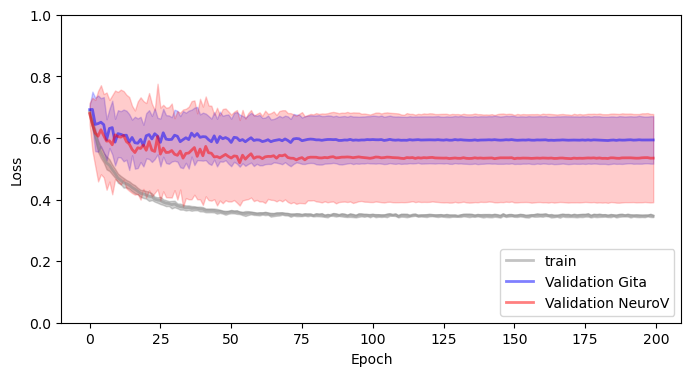

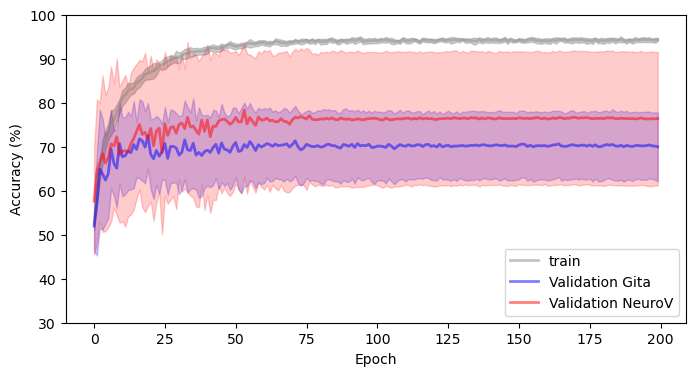

In [14]:
results_loss_Epochs_mean=np.stack(results_loss_Epochs,0).mean(axis=0)
results_loss_Epochs_std=np.stack(results_loss_Epochs,0).std(axis=0)

results_val_loss_Gita_Epochs_mean=np.stack(results_val_loss_Gita_Epochs,0).mean(axis=0)
results_val_loss_Gita_Epochs_std=np.stack(results_val_loss_Gita_Epochs,0).std(axis=0)

results_val_loss_NeuroV_Epochs_mean=np.stack(results_val_loss_NeuroV_Epochs,0).mean(axis=0)
results_val_loss_NeuroV_Epochs_std=np.stack(results_val_loss_NeuroV_Epochs,0).std(axis=0)

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(range(epoch+1),results_loss_Epochs_mean, alpha=0.5, color='#888888', label='train', linewidth = 2.0)
ax.fill_between(range(epoch+1), results_loss_Epochs_mean - results_loss_Epochs_std, results_loss_Epochs_mean + results_loss_Epochs_std, color='#888888', alpha=0.4)

ax.plot(range(epoch+1),results_val_loss_Gita_Epochs_mean, alpha=0.5, color='blue', label='Validation Gita', linewidth = 2.0)
ax.fill_between(range(epoch+1), results_val_loss_Gita_Epochs_mean - results_val_loss_Gita_Epochs_std, results_val_loss_Gita_Epochs_mean + results_val_loss_Gita_Epochs_std, color='blue', alpha=0.2)

ax.plot(range(epoch+1),results_val_loss_NeuroV_Epochs_mean, alpha=0.5, color='red', label='Validation NeuroV', linewidth = 2.0)
ax.fill_between(range(epoch+1), results_val_loss_NeuroV_Epochs_mean - results_val_loss_NeuroV_Epochs_std, results_val_loss_NeuroV_Epochs_mean + results_val_loss_NeuroV_Epochs_std, color='red', alpha=0.2)


ax.set_ylim([0,1])
ax.legend(loc='lower right')
ax.set_ylabel("Loss")
ax.set_xlabel("Epoch")
plt.savefig("Loss_Train_Validation.pdf", dpi=150)

results_metric_Epochs_mean=np.stack(results_metric_Epochs,0).mean(axis=0)
results_metric_Epochs_std=np.stack(results_metric_Epochs,0).std(axis=0)

results_val_metric_Gita_Epochs_mean=np.stack(results_val_metric_Gita_Epochs,0).mean(axis=0)
results_val_metric_Gita_Epochs_std=np.stack(results_val_metric_Gita_Epochs,0).std(axis=0)

results_val_metric_NeuroV_Epochs_mean=np.stack(results_val_metric_NeuroV_Epochs,0).mean(axis=0)
results_val_metric_NeuroV_Epochs_std=np.stack(results_val_metric_NeuroV_Epochs,0).std(axis=0)

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(range(epoch+1),results_metric_Epochs_mean, alpha=0.5, color='#888888', label='train', linewidth = 2.0)
ax.fill_between(range(epoch+1), results_metric_Epochs_mean - results_metric_Epochs_std, results_metric_Epochs_mean + results_metric_Epochs_std, color='#888888', alpha=0.4)

ax.plot(range(epoch+1),results_val_metric_Gita_Epochs_mean, alpha=0.5, color='blue', label='Validation Gita', linewidth = 2.0)
ax.fill_between(range(epoch+1), results_val_metric_Gita_Epochs_mean - results_val_metric_Gita_Epochs_std, results_val_metric_Gita_Epochs_mean + results_val_metric_Gita_Epochs_std, color='blue', alpha=0.2)

ax.plot(range(epoch+1),results_val_metric_NeuroV_Epochs_mean, alpha=0.5, color='red', label='Validation NeuroV', linewidth = 2.0)
ax.fill_between(range(epoch+1), results_val_metric_NeuroV_Epochs_mean - results_val_metric_NeuroV_Epochs_std, results_val_metric_NeuroV_Epochs_mean + results_val_metric_NeuroV_Epochs_std, color='red', alpha=0.2)


ax.set_ylim([30,100])
ax.legend(loc='lower right')

ax.set_ylabel("Accuracy (%)")
ax.set_xlabel("Epoch")
plt.savefig("Accuracy_Train_Validation.pdf", dpi=150)

In [15]:
print(f'Gita: Accuracy by windows:, {np.mean(val_windows_metrics_Gita):.2f} ({np.std(val_windows_metrics_Gita):.2f})%,Accuracy by subject:{np.mean(val_subject_metrics_Gita):.2f} ({np.std(val_subject_metrics_Gita):.2f})') 
print(f'NeuroV: Accuracy by windows:, {np.mean(val_windows_metrics_NeuroV):.2f} ({np.std(val_windows_metrics_NeuroV):.2f})%,Accuracy by subject:{np.mean(val_subject_metrics_NeuroV):.2f} ({np.std(val_subject_metrics_NeuroV):.2f})') 


Gita: Accuracy by windows:, 69.99 (7.78)%,Accuracy by subject:71.94 (8.84)
NeuroV: Accuracy by windows:, 76.39 (15.17)%,Accuracy by subject:76.67 (21.62)


In [16]:
def KLdivergence(x, y):
#  """Compute the Kullback-Leibler divergence between two multivariate samples.
#  Parameters
#  ----------
#  x : 2D array (n,d)
#    Samples from distribution P, which typically represents the true
#    distribution.
#  y : 2D array (m,d)
#    Samples from distribution Q, which typically represents the approximate
#    distribution.
#  Returns
#  -------
#  out : float
#    The estimated Kullback-Leibler divergence D(P||Q).
#  References
#  ----------
#  Pérez-Cruz, F. Kullback-Leibler divergence estimation of
#continuous distributions IEEE International Symposium on Information
#Theory, 2008.
#  """
  from scipy.spatial import cKDTree as KDTree

  # Check the dimensions are consistent
  x = np.atleast_2d(x)
  y = np.atleast_2d(y)

  n,d = x.shape
  m,dy = y.shape

  assert(d == dy)


  # Build a KD tree representation of the samples and find the nearest neighbour
  # of each point in x.
  xtree = KDTree(x)
  ytree = KDTree(y)

  # Get the first two nearest neighbours for x, since the closest one is the
  # sample itself.
  r = xtree.query(x, k=2, eps=.01, p=2)[0][:,1]
  s = ytree.query(x, k=1, eps=.01, p=2)[0]

  # There is a mistake in the paper. In Eq. 14, the right side misses a negative sign
  # on the first term of the right hand side.
  return -np.log(r/s).sum() * d / n + np.log(m / (n - 1.))

In [17]:
KL_HC_1, KL_PD_1=[], []
KL_HC_2, KL_PD_2=[], []


for k in range(10):
    KL_HC_1.append(KLdivergence(flattern_output_CNN_Gita[k].data.cpu()[np.where(Y_val_Gita_fold[k]==0)], flattern_output_CNN_NeuroV[k].data.cpu()[np.where(Y_val_NeuroV_fold[k]==0)]))
    KL_HC_2.append(KLdivergence(flattern_output_CNN_NeuroV[k].data.cpu()[np.where(Y_val_NeuroV_fold[k]==0)], flattern_output_CNN_Gita[k].data.cpu()[np.where(Y_val_Gita_fold[k]==0)]))
    
    KL_PD_1.append(KLdivergence(flattern_output_CNN_Gita[k].data.cpu()[np.where(Y_val_Gita_fold[k]==1)], flattern_output_CNN_NeuroV[k].data.cpu()[np.where(Y_val_NeuroV_fold[k]==1)]))
    KL_PD_2.append(KLdivergence(flattern_output_CNN_NeuroV[k].data.cpu()[np.where(Y_val_NeuroV_fold[k]==1)], flattern_output_CNN_Gita[k].data.cpu()[np.where(Y_val_Gita_fold[k]==1)]))
   

    
print(f'KL para HC, {np.mean(KL_HC_1):.2f} ({np.std(KL_HC_1):.2f})')
print(f'KL para HC, {np.mean(KL_HC_2):.2f} ({np.std(KL_HC_2):.2f})')

print(f'KL para PD, {np.mean(KL_PD_1):.2f} ({np.std(KL_PD_1):.2f})')
print(f'KL para PD, {np.mean(KL_PD_2):.2f} ({np.std(KL_PD_2):.2f})')
print('')

print(f'KL para HC, {np.mean([KL_HC_1, KL_HC_2]):.2f} ({np.std([KL_HC_1, KL_HC_2]):.2f})')
print(f'KL para PD, {np.mean([KL_PD_1, KL_PD_2]):.2f} ({np.std([KL_PD_1, KL_PD_2]):.2f})')
      

KL para HC, 38.61 (10.70)
KL para HC, 59.04 (6.47)
KL para PD, 46.67 (8.79)
KL para PD, 54.56 (9.41)

KL para HC, 48.83 (13.51)
KL para PD, 50.62 (9.92)


In [18]:
Variance_HC, Variance_PD=[],[]
for k in range(10):
    Gita_features_HC=flattern_output_CNN_Gita[k].data.cpu()[np.where(Y_val_Gita_fold[k]==0)]
    NeuroV_features_HC=flattern_output_CNN_NeuroV[k].data.cpu()[np.where(Y_val_NeuroV_fold[k]==0)]
    Gita_features_PD=flattern_output_CNN_Gita[k].data.cpu()[np.where(Y_val_Gita[k]==1)]
    NeuroV_features_PD=flattern_output_CNN_NeuroV[k].data.cpu()[np.where(Y_val_NeuroV_fold[k]==1)]

    features_HC=torch.concat([Gita_features_HC, NeuroV_features_HC])
    features_PD=torch.concat([Gita_features_PD, NeuroV_features_PD])
    Variance_HC.append(np.trace(np.cov(np.transpose(features_HC))))
    Variance_PD.append(np.trace(np.cov(np.transpose(features_PD))))

print(f'Cov para HC, {np.mean(Variance_HC):.2f} ({np.std(Variance_HC):.2f})')
print(f'Cov para PD, {np.mean(Variance_PD):.2f} ({np.std(Variance_PD):.2f})')



Cov para HC, 33.23 (14.96)
Cov para PD, 17.10 (4.47)


In [19]:
def plot_embedding(X, y, d, title=None):
    """Plot an embedding X with the class label y colored by the domain d."""
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)
    # Plot colors numbers
    plt.figure(figsize=(10,10))
    ax = plt.subplot(111)
    colores=[(0,0.6,1), (0,0,1), (1,0.5,0.5), (1,0,0)  ]
   
    for i in range(X.shape[0]):
        # plot colored number
        #plt.text(X[i, 0], X[i, 1], 'o',
        #         color=colores[y[i]],
        #         fontdict={ 'size': 14})
        plt.plot(X[i, 0], X[i, 1], 'o',
                 color=colores[y[i]],#plt.cm.brw(y[i]),
                  )
         
    plt.xticks([]), plt.yticks([])
    plt.legend(['Gita_HC', 'Gita_PD', 'NeuroV_HC', 'NeuroV_PD'] )
    ax = plt.gca()
    leg = ax.get_legend()
    leg.legendHandles[0].set_color((0,0.6,1))
    leg.legendHandles[1].set_color((0,0,1))
    leg.legendHandles[2].set_color((1,0.5,0.5))
    leg.legendHandles[3].set_color((1,0,0))
    if title is not None:
        plt.title(title)
    

/tmp/ipykernel_433181/1976475080.py:23: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[0].set_color((0,0.6,1))
/tmp/ipykernel_433181/1976475080.py:24: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[1].set_color((0,0,1))
/tmp/ipykernel_433181/1976475080.py:25: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[2].set_color((1,0.5,0.5))
/tmp/ipykernel_433181/1976475080.py:26: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[3].set_color((1,0,0))


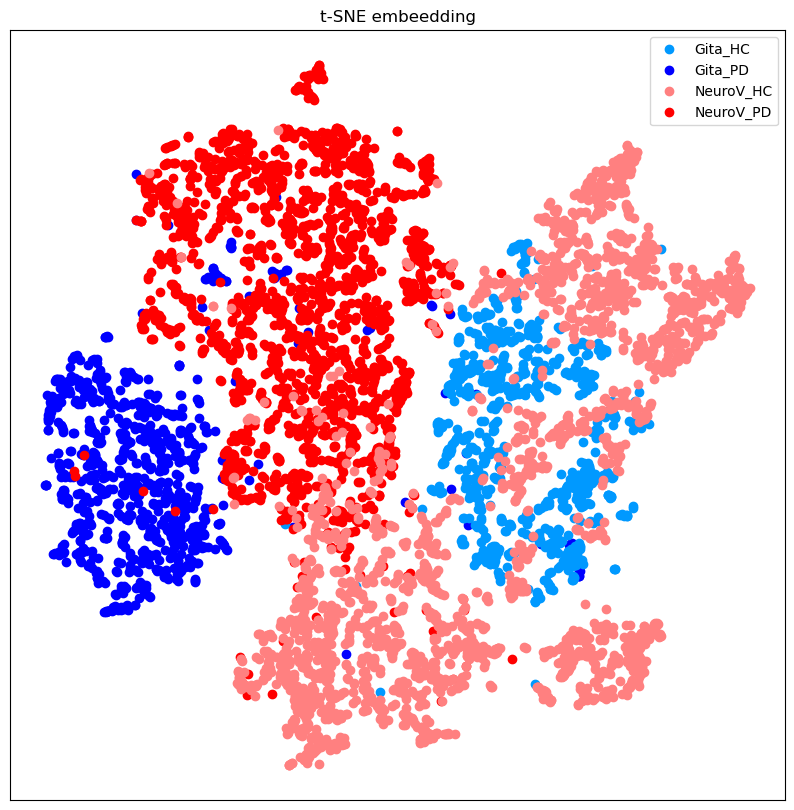

/tmp/ipykernel_433181/1976475080.py:23: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[0].set_color((0,0.6,1))
/tmp/ipykernel_433181/1976475080.py:24: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[1].set_color((0,0,1))
/tmp/ipykernel_433181/1976475080.py:25: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[2].set_color((1,0.5,0.5))
/tmp/ipykernel_433181/1976475080.py:26: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[3].set_color((1,0,0))


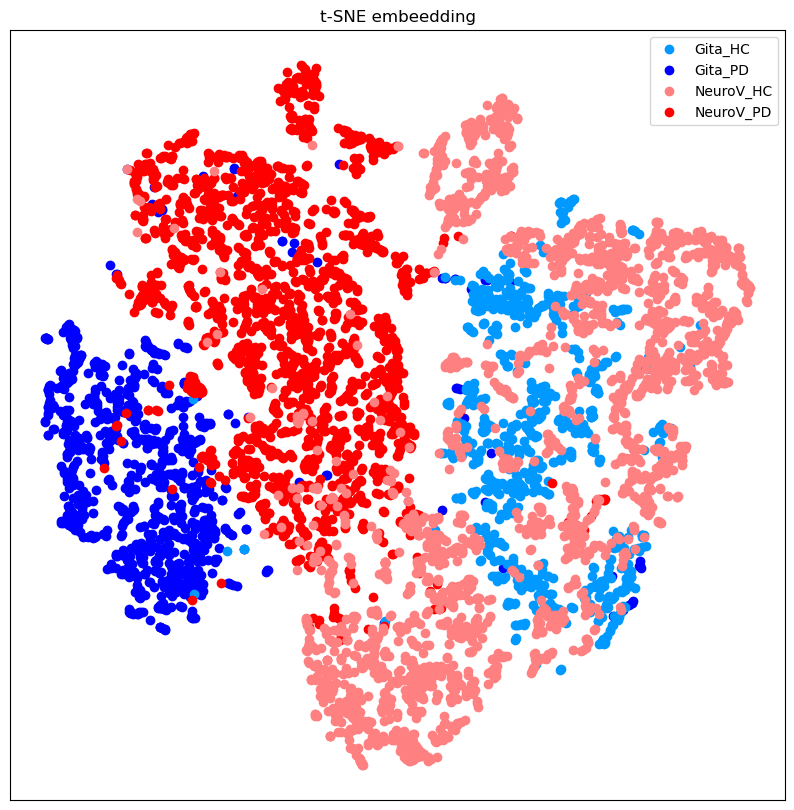

/tmp/ipykernel_433181/1976475080.py:23: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[0].set_color((0,0.6,1))
/tmp/ipykernel_433181/1976475080.py:24: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[1].set_color((0,0,1))
/tmp/ipykernel_433181/1976475080.py:25: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[2].set_color((1,0.5,0.5))
/tmp/ipykernel_433181/1976475080.py:26: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[3].set_color((1,0,0))


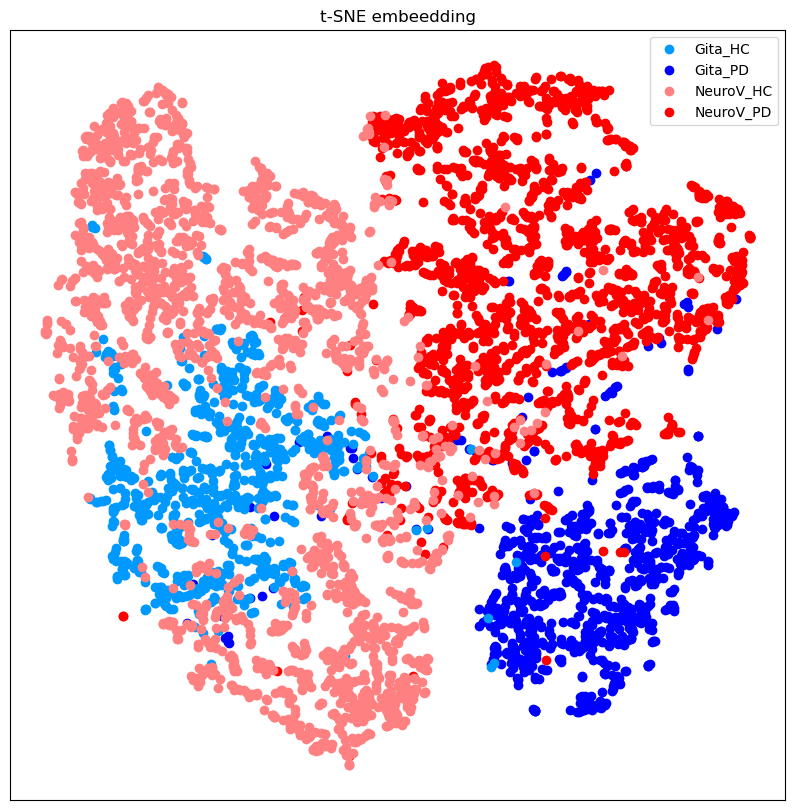

/tmp/ipykernel_433181/1976475080.py:23: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[0].set_color((0,0.6,1))
/tmp/ipykernel_433181/1976475080.py:24: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[1].set_color((0,0,1))
/tmp/ipykernel_433181/1976475080.py:25: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[2].set_color((1,0.5,0.5))
/tmp/ipykernel_433181/1976475080.py:26: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[3].set_color((1,0,0))


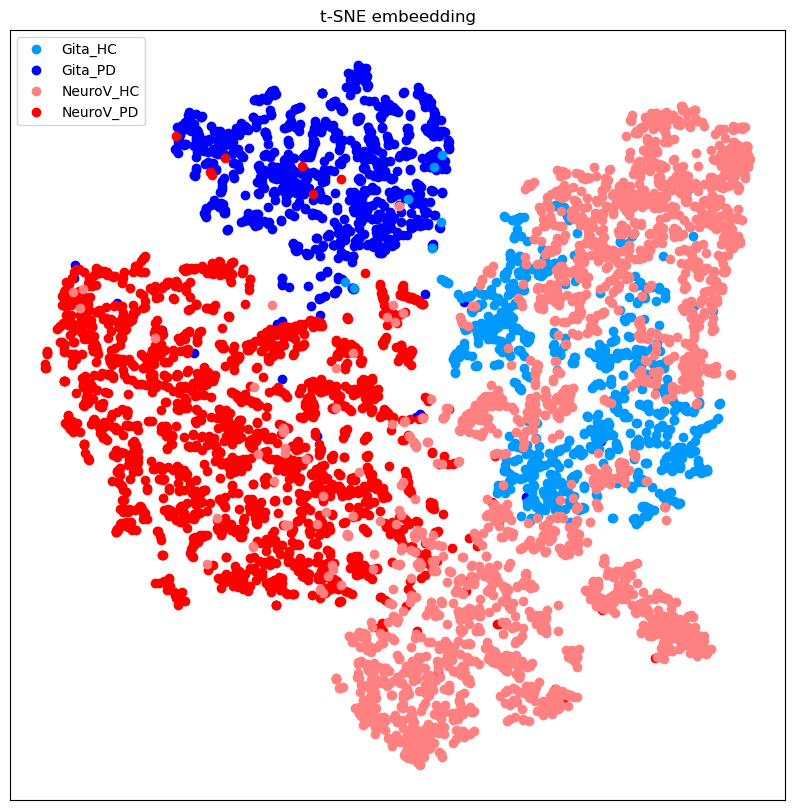

/tmp/ipykernel_433181/1976475080.py:23: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[0].set_color((0,0.6,1))
/tmp/ipykernel_433181/1976475080.py:24: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[1].set_color((0,0,1))
/tmp/ipykernel_433181/1976475080.py:25: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[2].set_color((1,0.5,0.5))
/tmp/ipykernel_433181/1976475080.py:26: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[3].set_color((1,0,0))


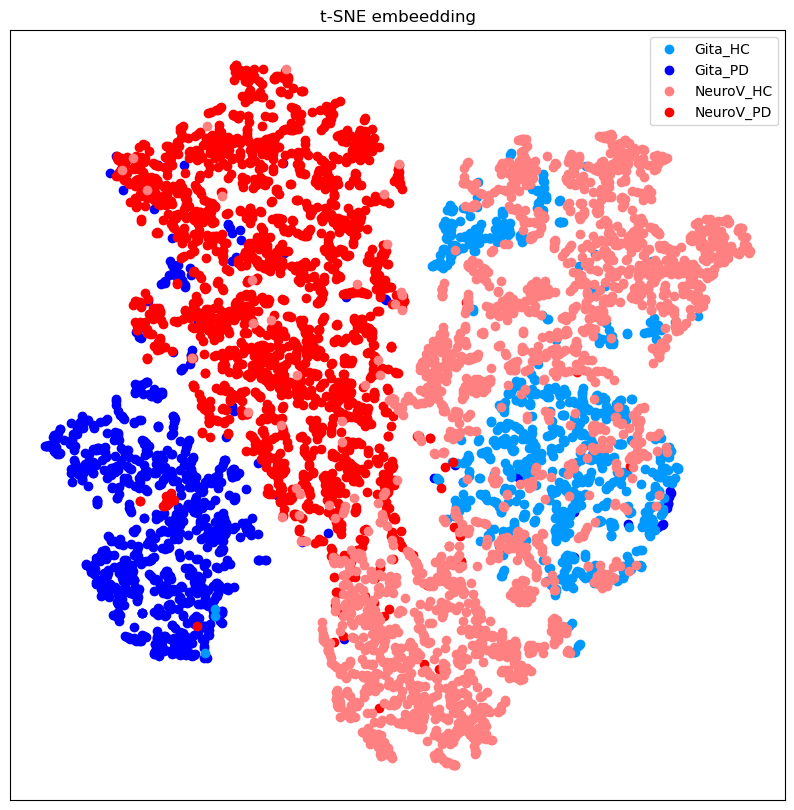

/tmp/ipykernel_433181/1976475080.py:23: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[0].set_color((0,0.6,1))
/tmp/ipykernel_433181/1976475080.py:24: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[1].set_color((0,0,1))
/tmp/ipykernel_433181/1976475080.py:25: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[2].set_color((1,0.5,0.5))
/tmp/ipykernel_433181/1976475080.py:26: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[3].set_color((1,0,0))


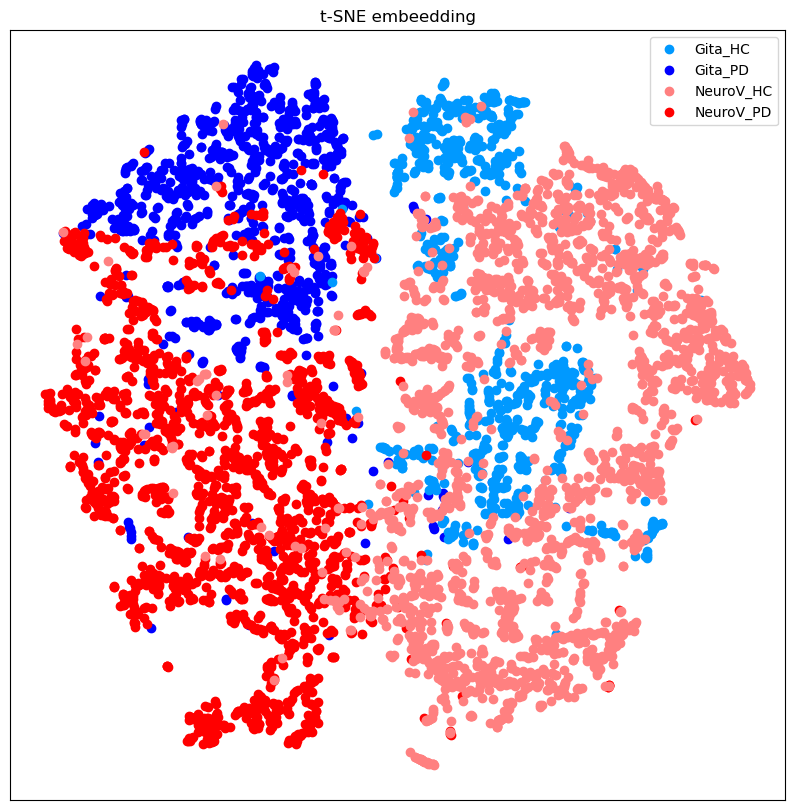

/tmp/ipykernel_433181/1976475080.py:23: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[0].set_color((0,0.6,1))
/tmp/ipykernel_433181/1976475080.py:24: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[1].set_color((0,0,1))
/tmp/ipykernel_433181/1976475080.py:25: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[2].set_color((1,0.5,0.5))
/tmp/ipykernel_433181/1976475080.py:26: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[3].set_color((1,0,0))


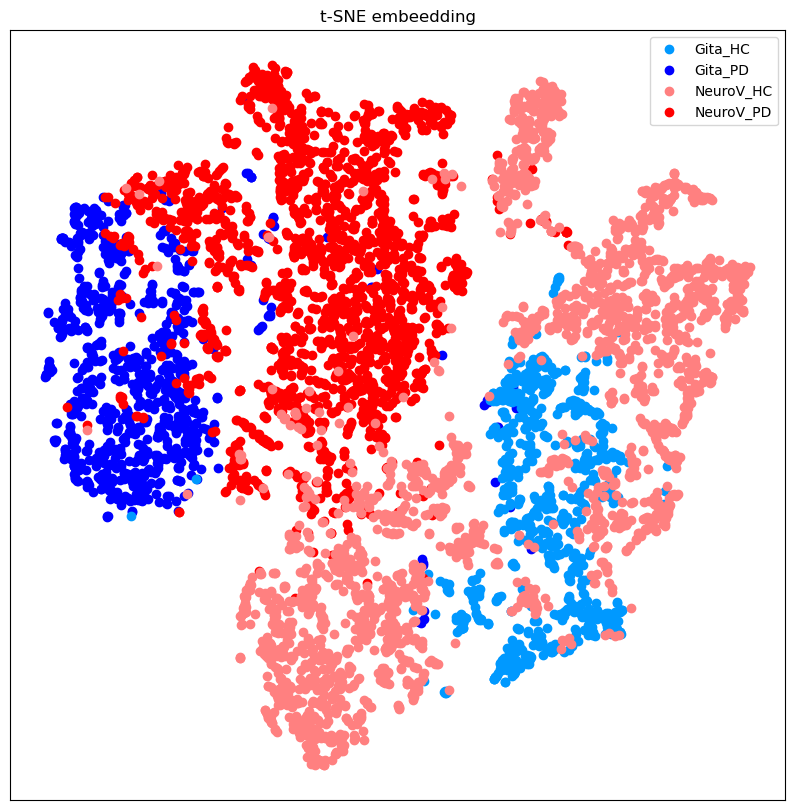

/tmp/ipykernel_433181/1976475080.py:23: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[0].set_color((0,0.6,1))
/tmp/ipykernel_433181/1976475080.py:24: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[1].set_color((0,0,1))
/tmp/ipykernel_433181/1976475080.py:25: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[2].set_color((1,0.5,0.5))
/tmp/ipykernel_433181/1976475080.py:26: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[3].set_color((1,0,0))


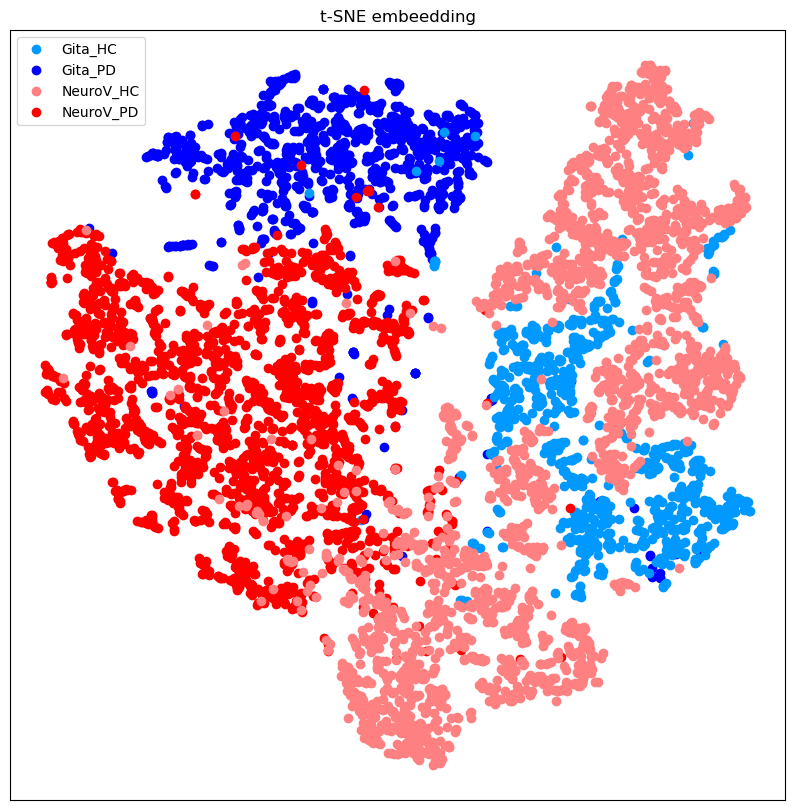

/tmp/ipykernel_433181/1976475080.py:23: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[0].set_color((0,0.6,1))
/tmp/ipykernel_433181/1976475080.py:24: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[1].set_color((0,0,1))
/tmp/ipykernel_433181/1976475080.py:25: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[2].set_color((1,0.5,0.5))
/tmp/ipykernel_433181/1976475080.py:26: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[3].set_color((1,0,0))


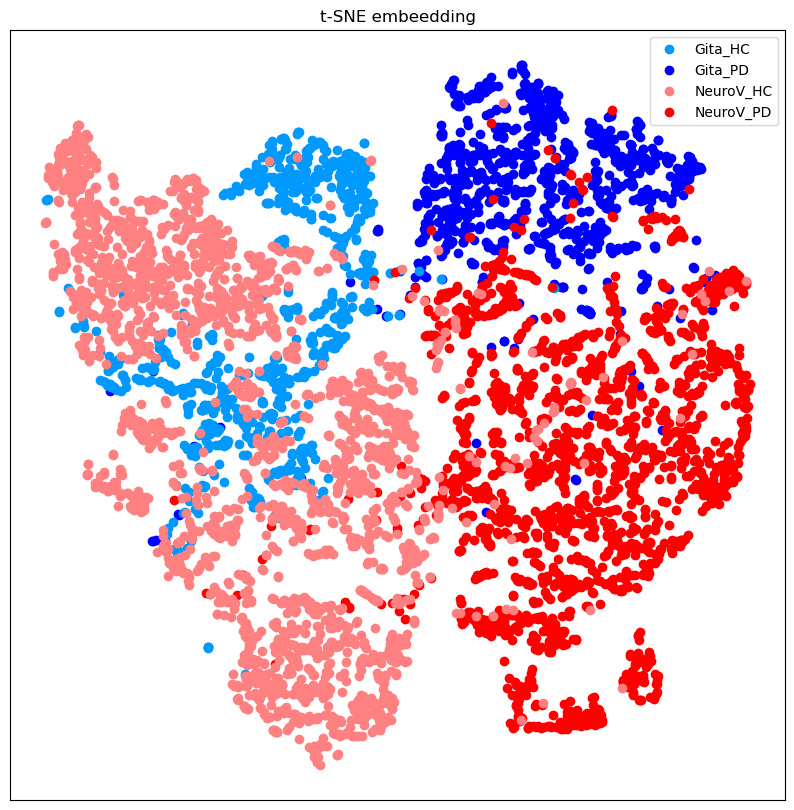

/tmp/ipykernel_433181/1976475080.py:23: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[0].set_color((0,0.6,1))
/tmp/ipykernel_433181/1976475080.py:24: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[1].set_color((0,0,1))
/tmp/ipykernel_433181/1976475080.py:25: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[2].set_color((1,0.5,0.5))
/tmp/ipykernel_433181/1976475080.py:26: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[3].set_color((1,0,0))


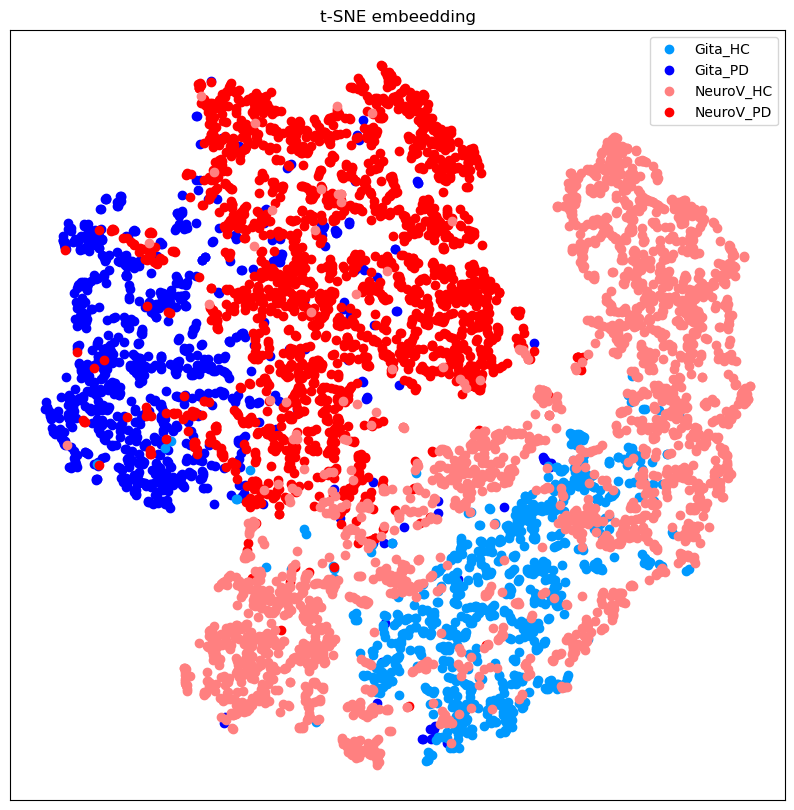

In [20]:
t_SNE= TSNE(n_components=2,n_iter=500,n_iter_without_progress=150, n_jobs=2, random_state=0)

for k in range(10):
    CCN_train=np.concatenate([flattern_train_CNN_Gita[k].data.cpu(), flattern_train_CNN_NeuroV[k].data.cpu()])
    Y_train=np.concatenate([Y_train_Gita_fold[k].data.cpu(), Y_train_NeuroV_fold[k].data.cpu()])
    Y_train_plot=np.concatenate([Y_train_Gita_fold[k].data.cpu(), Y_train_NeuroV_fold[k].data.cpu()+2])   
    domain_train=np.concatenate([np.zeros(Y_train_Gita_fold[k].shape), np.ones( Y_train_NeuroV_fold[k].shape)])

    projections=t_SNE.fit_transform(CCN_train,Y_train)
       
    plot_embedding(projections,Y_train_plot,domain_train, 't-SNE embeedding')
   
    plt.show()


/tmp/ipykernel_433181/1976475080.py:23: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[0].set_color((0,0.6,1))
/tmp/ipykernel_433181/1976475080.py:24: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[1].set_color((0,0,1))
/tmp/ipykernel_433181/1976475080.py:25: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[2].set_color((1,0.5,0.5))
/tmp/ipykernel_433181/1976475080.py:26: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[3].set_color((1,0,0))


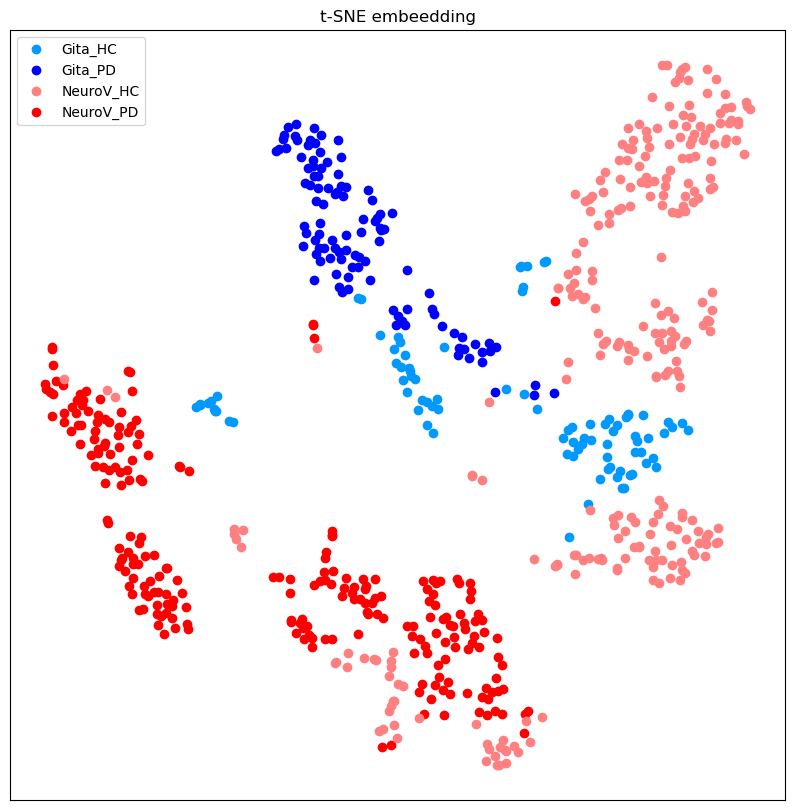

/tmp/ipykernel_433181/1976475080.py:23: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[0].set_color((0,0.6,1))
/tmp/ipykernel_433181/1976475080.py:24: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[1].set_color((0,0,1))
/tmp/ipykernel_433181/1976475080.py:25: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[2].set_color((1,0.5,0.5))
/tmp/ipykernel_433181/1976475080.py:26: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[3].set_color((1,0,0))


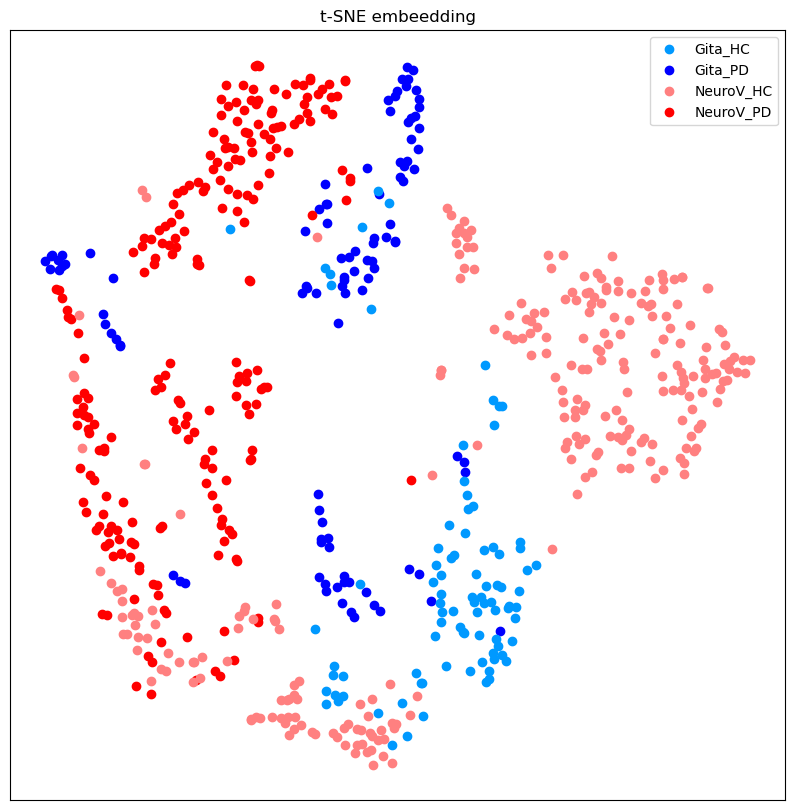

/tmp/ipykernel_433181/1976475080.py:23: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[0].set_color((0,0.6,1))
/tmp/ipykernel_433181/1976475080.py:24: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[1].set_color((0,0,1))
/tmp/ipykernel_433181/1976475080.py:25: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[2].set_color((1,0.5,0.5))
/tmp/ipykernel_433181/1976475080.py:26: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[3].set_color((1,0,0))


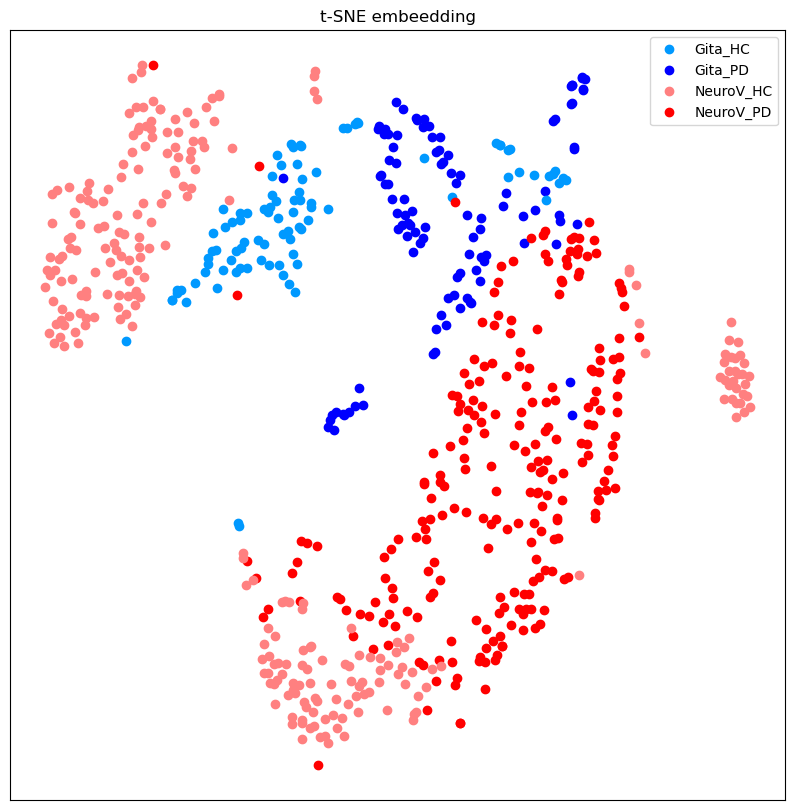

/tmp/ipykernel_433181/1976475080.py:23: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[0].set_color((0,0.6,1))
/tmp/ipykernel_433181/1976475080.py:24: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[1].set_color((0,0,1))
/tmp/ipykernel_433181/1976475080.py:25: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[2].set_color((1,0.5,0.5))
/tmp/ipykernel_433181/1976475080.py:26: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[3].set_color((1,0,0))


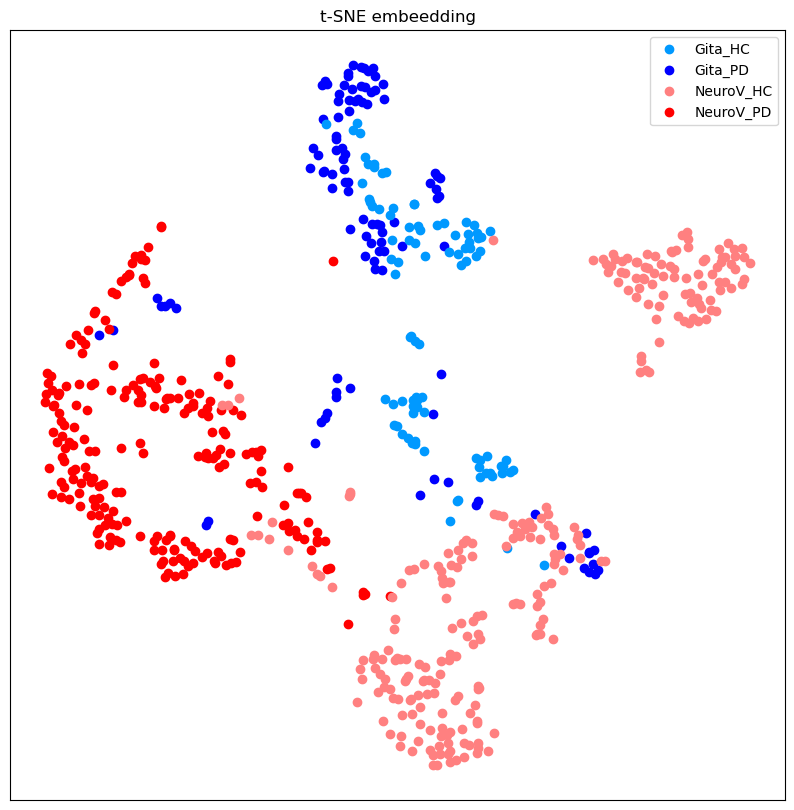

/tmp/ipykernel_433181/1976475080.py:23: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[0].set_color((0,0.6,1))
/tmp/ipykernel_433181/1976475080.py:24: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[1].set_color((0,0,1))
/tmp/ipykernel_433181/1976475080.py:25: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[2].set_color((1,0.5,0.5))
/tmp/ipykernel_433181/1976475080.py:26: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[3].set_color((1,0,0))


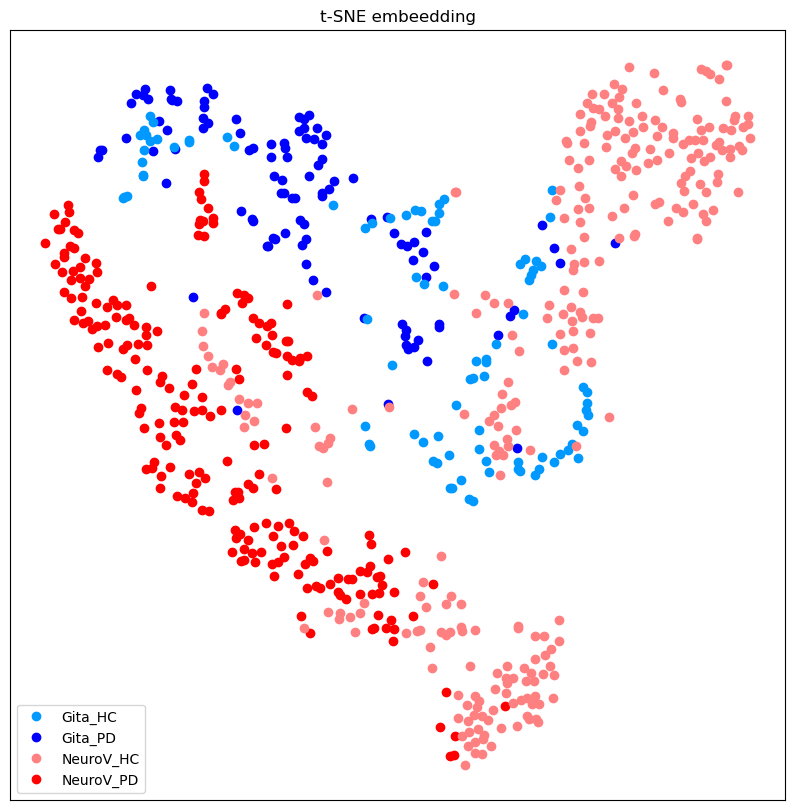

/tmp/ipykernel_433181/1976475080.py:23: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[0].set_color((0,0.6,1))
/tmp/ipykernel_433181/1976475080.py:24: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[1].set_color((0,0,1))
/tmp/ipykernel_433181/1976475080.py:25: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[2].set_color((1,0.5,0.5))
/tmp/ipykernel_433181/1976475080.py:26: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[3].set_color((1,0,0))


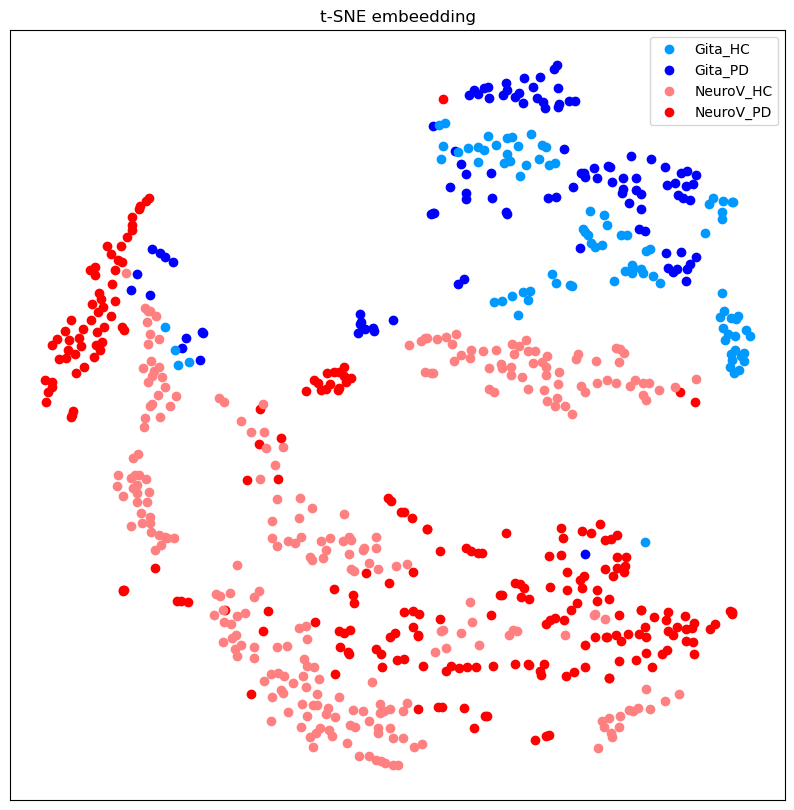

/tmp/ipykernel_433181/1976475080.py:23: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[0].set_color((0,0.6,1))
/tmp/ipykernel_433181/1976475080.py:24: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[1].set_color((0,0,1))
/tmp/ipykernel_433181/1976475080.py:25: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[2].set_color((1,0.5,0.5))
/tmp/ipykernel_433181/1976475080.py:26: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[3].set_color((1,0,0))


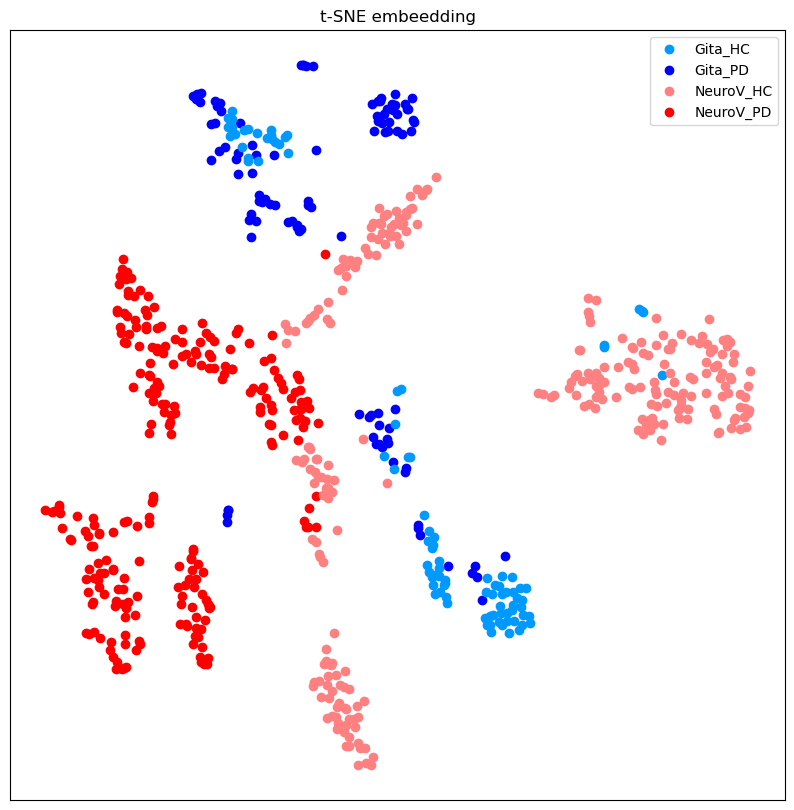

/tmp/ipykernel_433181/1976475080.py:23: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[0].set_color((0,0.6,1))
/tmp/ipykernel_433181/1976475080.py:24: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[1].set_color((0,0,1))
/tmp/ipykernel_433181/1976475080.py:25: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[2].set_color((1,0.5,0.5))
/tmp/ipykernel_433181/1976475080.py:26: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[3].set_color((1,0,0))


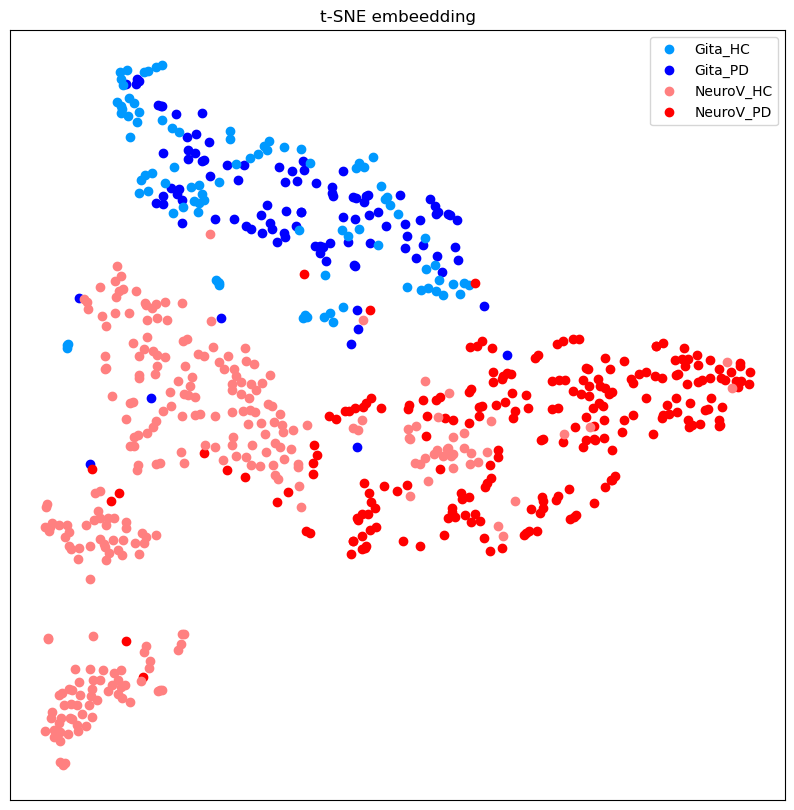

/tmp/ipykernel_433181/1976475080.py:23: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[0].set_color((0,0.6,1))
/tmp/ipykernel_433181/1976475080.py:24: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[1].set_color((0,0,1))
/tmp/ipykernel_433181/1976475080.py:25: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[2].set_color((1,0.5,0.5))
/tmp/ipykernel_433181/1976475080.py:26: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[3].set_color((1,0,0))


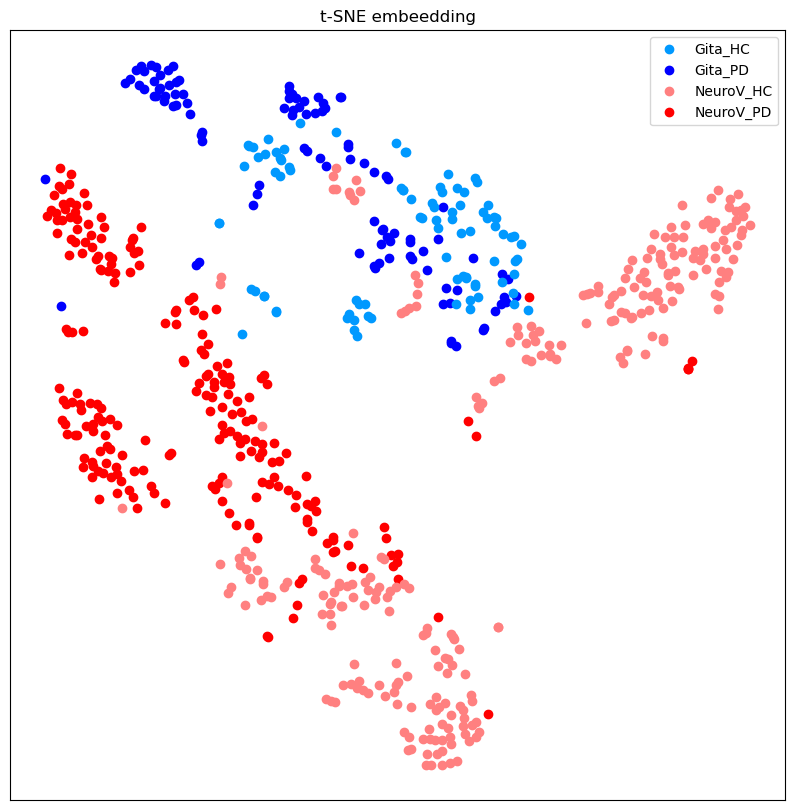

/tmp/ipykernel_433181/1976475080.py:23: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[0].set_color((0,0.6,1))
/tmp/ipykernel_433181/1976475080.py:24: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[1].set_color((0,0,1))
/tmp/ipykernel_433181/1976475080.py:25: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[2].set_color((1,0.5,0.5))
/tmp/ipykernel_433181/1976475080.py:26: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[3].set_color((1,0,0))


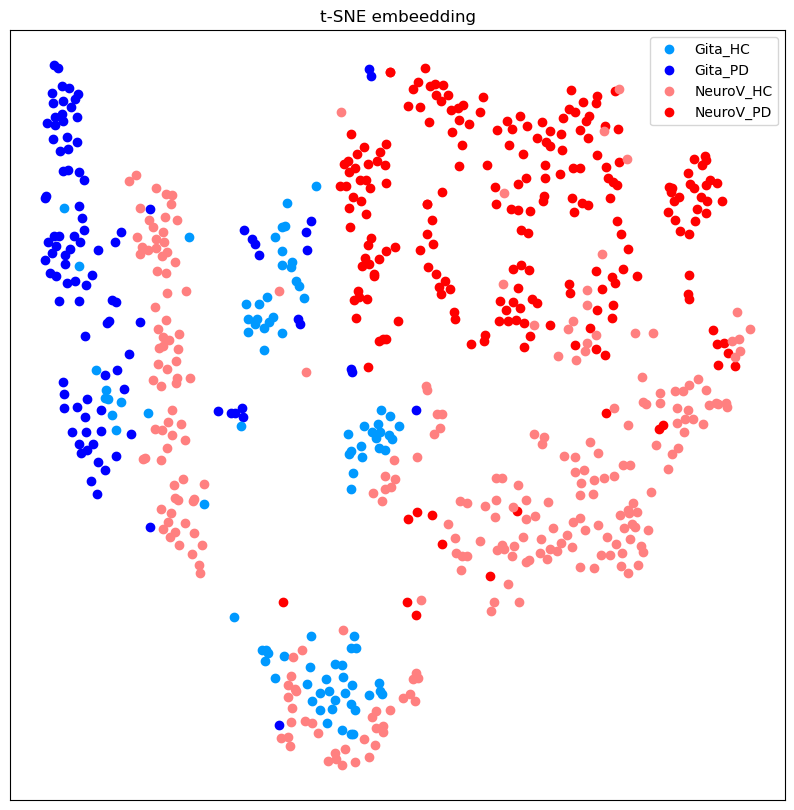

In [21]:
t_SNE= TSNE(n_components=2,n_iter=500,n_iter_without_progress=150, n_jobs=2, random_state=0)

for k in range(10):
    CCN_out=np.concatenate([flattern_output_CNN_Gita[k].data.cpu(), flattern_output_CNN_NeuroV[k].data.cpu()])
    Y_test=np.concatenate([Y_val_Gita_fold[k], Y_val_NeuroV_fold[k]])
    Y_test_plot=np.concatenate([Y_val_Gita_fold[k], Y_val_NeuroV_fold[k]+2])   
    domain_test=np.concatenate([np.zeros(Y_val_Gita_fold[k].shape), np.ones( Y_val_NeuroV_fold[k].shape)])

    projections=t_SNE.fit_transform(CCN_out,Y_test)
       
    plot_embedding(projections,Y_test_plot,domain_test, 't-SNE embeedding')
   
    plt.show()